In [2]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Jedi not working
%config Completer.use_jedi = False

In [3]:
retail_df = pd.read_csv("online_retail_10-11.csv")
retail_09_10_df = pd.read_csv("online_retail_09-10.csv", parse_dates=['InvoiceDate'])

In [4]:
retail_09_10_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
retail_09_10_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
retail_09_10_df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [7]:
retail_09_10_df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

<AxesSubplot:>

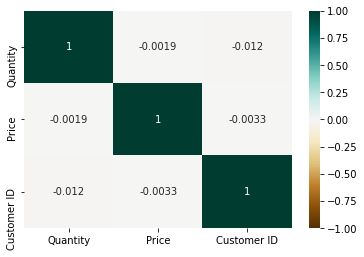

In [8]:
sns.heatmap(retail_09_10_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [9]:
print(retail_09_10_df['InvoiceDate'].min(), retail_09_10_df['InvoiceDate'].max())

2009-12-01 07:45:00 2010-12-09 20:01:00


In [17]:
# Max date defined as "today" for counting days

sd = dt.datetime(2010, 12, 9)

uk_retail_df = retail_09_10_df[retail_09_10_df['Country']== "United Kingdom"]

rfm_df = uk_retail_df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (sd - x.max()).days,
                                     'Invoice': lambda x: len(x),
                                     'Price': lambda x: x.sum()})

rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

In [18]:
rfm_df

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,65,46,578.36
12608.0,38,16,26.04
12745.0,120,22,67.98
12746.0,161,20,73.95
12747.0,3,162,716.11
...,...,...,...
18283.0,16,230,498.82
18284.0,63,29,116.09
18285.0,294,12,100.20


In [24]:
# Discretization into buckets based on quantiles

rfm_df["RecencyScore"] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df["FrequencyScore"] = pd.qcut(rfm_df['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_df["MonetaryScore"] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm_df["RFM_SCORE"] = (rfm_df['RecencyScore'].astype(str) +
                    rfm_df['FrequencyScore'].astype(str) +
                    rfm_df['MonetaryScore'].astype(str))

In [25]:
# RFM segmentation mapping
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

In [28]:
# Agg segmentation
rfm_df['Segment'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(seg_map, regex=True)
rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346.0,65,46,578.36,3,3,5,335,Need_Attention
12608.0,38,16,26.04,3,2,1,321,About_to_Sleep
12745.0,120,22,67.98,2,2,2,222,Hibernating
12746.0,161,20,73.95,2,2,2,222,Hibernating
12747.0,3,162,716.11,5,5,5,555,Champions


In [29]:
rfm_df[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count","std"])

Recency                    Frequency        \
                           mean count        std        mean count   
Segment                                                              
About_to_Sleep        50.471875   320  10.191850   15.459375   320   
At_Risk              159.421053   570  80.158553   58.215789   570   
Cant_Loose           123.534884    86  50.772780  232.046512    86   
Champions              4.732899   614   4.512118  261.314332   614   
Hibernating          207.668410   956  90.729319   13.424686   956   
Loyal_Customers       34.721358   707  15.875762  173.205092   707   
Need_Attention        48.276316   152  10.264191   45.730263   152   
New_Customers          5.783333    60   4.333909    7.216667    60   
Potential_Loyalists   15.157895   475   9.308945   36.709474   475   
Promising             22.421053    95   5.158300    8.200000    95   

                                   Monetary                     
                            std        mean count          std  
Segment                                                         
About_to_Sleep         8.642947  157.263844   320  1002.325505  
At_Risk               24.071308  185.023512   570   110.579890  
Cant_Loose           162.221048  705.643500    86   686.948763  
Champions            370.497612  851.894502   614  1413.504487  
Hibernating            8.644677  157.522742   956  1387.520343  
Loyal_Customers      154.443657  520.840983   707   442.555837  
Need_Attention         8.535838  411.011908   152  3227.238742  
New_Customers          3.987658   33.589500    60    43.270695  
Potential_Loyalists   13.253445  126.599411   475   118.514052  
Promising              3.891070   33.052632    95    32.215465